In [1]:
'''
Modified By Sohaib Anwaar (sohaibanwaar36@gmail.com)

This code is modified for tensorflow 2.

Hardware and software Compatibility:

    3070 RTX nvidia
    Intel 10400F processor (CPU)
    Ubuntu 18.04
    tensorflow 2.0
'''




import matplotlib.pyplot as plt
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.edsr import edsr
from train import EdsrTrainer

%matplotlib inline

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6



# Loading Weights

## EDSR

In [2]:
weights_dir = f'weights/edsr-4x_weights'
weights_file = os.path.join(weights_dir, 'weights.h5')

In [3]:
model = edsr(scale=4, num_res_blocks=16)
model.load_weights(weights_file)

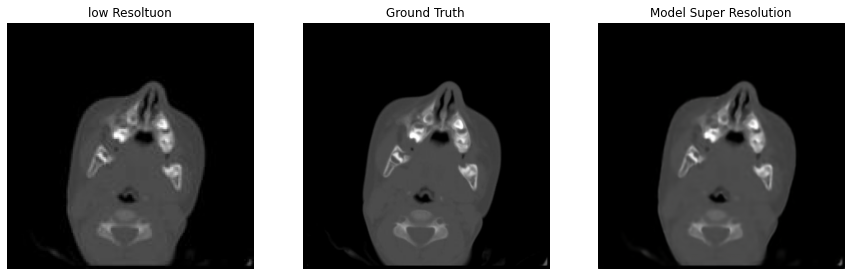

In [4]:
from model import resolve_single
from utils import load_image, plot_sample

from model import resolve_single
from utils import load_image, plot_sample


def display(display_list):
    
    labels_list = ["low Resoltuon", "Ground Truth", "Model Super Resolution"]
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        
        plt.subplot(1, len(display_list), i+1)
        plt.title(labels_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

def resolve_and_plot(lr_image_path, gt_lr_image_path):
    lr = load_image(lr_image_path)
    gt = load_image(gt_lr_image_path)
    sr = resolve_single(model, lr)
    display([lr, gt, sr])


resolve_and_plot('docs/images/testing_image.jpg', 'docs/images/gt_testing_image.jpg')

# SR Gans

## 

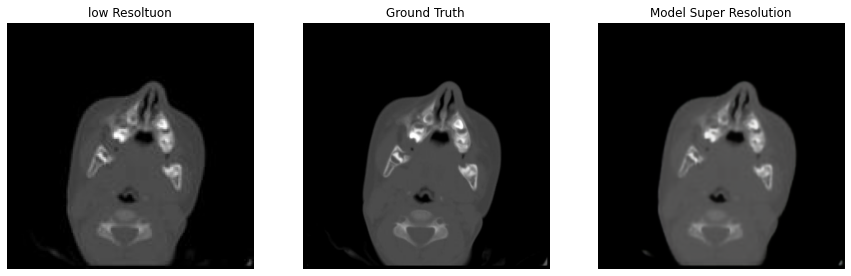

In [5]:
from model.srgan import generator, discriminator
from train import SrganTrainer, SrganGeneratorTrainer

# Location of model weights (needed for demo)
weights_dir = 'weights/srgan_4x'
weights_file = lambda filename: os.path.join(weights_dir, filename)
pre_generator = generator()

pre_generator.load_weights(weights_file('pre_generator.h5'))

from model import resolve_single
from utils import load_image

def resolve_and_plot(lr_image_path, gt_lr_image_path):
    lr = load_image(lr_image_path)
    gt = load_image(gt_lr_image_path)
    sr = resolve_single(pre_generator, lr)
    display([lr, gt, sr])


resolve_and_plot('docs/images/testing_image.jpg', 'docs/images/gt_testing_image.jpg')

    
    

# Test and Etrain Evaluation

In [6]:
import os
import tensorflow as tf
import glob
from tensorflow.python.data.experimental import AUTOTUNE


class Data_generator:
    
    def __init__(self,
                 scale            =4,
                 train_images_dir ='div2k/images',
                 val_images_dir   ='div2k/caches'):
        
        self.train_images_dir = train_images_dir
        self.val_images_dir   = val_images_dir
        self.caches_dir       = ""
        self.scale            = scale
    
    
    def get_images_list(self, path):
        '''
            Description:
                Getting the paths of the low and high resolution images,

            Input:
                Path   (str) : path of the main directory (train or val)

            Output:

                hr_images_path (str) : High resoltion images inside the parent directory
                lr_images_path (str) : low resolution image inside the parent directory        
        
        '''
        # Initilzing Lists
        hr_images_paths = []
        lr_images_paths = []
        
        # loop through the high resolution image
        for hr_path in glob.glob(path+"/hr/*.*g"):
            
            # Getting the base path and image name
            base_path, _ ,image_name = hr_path.rsplit("/",2)
            
            # Creating low resolution image path (name of hr and lr image should be same)
            lr_path = f"{base_path}/lr/{image_name}"  
            
            # Appending high resoltion Image and low resolution image in list
            hr_images_paths.append(hr_path) 
            lr_images_paths.append(lr_path)
        
        # Returning Images
        return hr_images_paths, lr_images_paths
    


    def dataset(self, batch_size=4, repeat_count=None, random_transform=True):
        '''
            Description:
                    This function is used to convert Images path to a tensorflow variable or dataset so that
                    we are able to pass it to the model for trainig. This function also use augmentation 
                    fucntion which augment the image 
                        Augmentaion:
                            1. Rotate Image
                            2. Flip Image
            Input:
                batch_size        (int)  : Batch size given to the generator to take n samples on 1 call
                repeat_count      (int)  : How many time you want to repeat the image
                random trainform  (bool) : True for Augmentation 

            Output:
                train_ds    (tf.gen)  : Training Dataset tensorflow variable
                val_ds      (tf.gen)  : Validation Dataset Tensorflow variable
        '''
        
        self.dataset_files()
        train_ds = tf.data.Dataset.zip((self.train_lr, self.train_hr))
        val_ds   = tf.data.Dataset.zip((self.val_lr, self.val_hr))
        
        def augment_data(ds):
            '''
                Description:
                    This dataset is used to augment the images 
                        1. Random Rotate : Randomly rotate the image from (0, 360)
                        2. Random_flip   : Random flip the image (top, left, right, bottom)

                Input:
                    ds   (tf.gen) : Tensorflow generator

                Output:
                    ds  (tf.gen) : Augmented tensorflow generator
            
            '''
            # Augmentation
            if random_transform:
                
                # Random Flip
                ds = ds.map(random_flip, num_parallel_calls=AUTOTUNE)
            
            # Setting Batch size
            ds = ds.batch(batch_size)
            
            # Repeat Counter
            ds = ds.repeat(repeat_count)
            
            # Prefetch
            ds = ds.prefetch(buffer_size=AUTOTUNE)
            return ds
        
        # Getting ready with tensorflow train and val generator after agumentation
        train_ds = augment_data(train_ds)
        val_ds = augment_data(val_ds)
        return train_ds, val_ds


    
    def dataset_files(self):
        '''
            Description
                Getting the dataset Paths High resoltion and low resolution training and
                validation images paths so that it can be converted into tf.generators
                later

            Input:
                No Input will take class variables

            Output:
                No Output will store results in class variables
        
        
        '''
        
        # Initilizing List
        hr_images, lr_images = [], []
        
        # Getting Training Images Path
        self.train_hr, self.train_lr  = self.get_images_list(self.train_images_dir)
        
        # Getting validation Images Path
        self.val_hr, self.val_lr      = self.get_images_list(self.val_images_dir)
        
        # Converting Paths to Tensorflow Generator 
        self.train_hr = self._images_dataset(self.train_hr)
        self.train_lr = self._images_dataset(self.train_lr)
        self.val_hr = self._images_dataset(self.val_hr)
        self.val_lr = self._images_dataset(self.val_lr)
        
        
        
        
        
    


    @staticmethod
    def _images_dataset(image_files):
        '''
            Description:
                This static fucntion is used to convert Images path list to a tensorflow generator
                by reading the files from the list.

            Input:
                image_files   (list) : List of the images

            Output:
                ds            (tf.gen) : Return tensorflow dataset variable also said to be data generator
        
        
        '''
        
        
        ds = tf.data.Dataset.from_tensor_slices(image_files)
        
        # Reading Image
        ds = ds.map(tf.io.read_file)
        
        # Removing alpha channel from png
        ds = ds.map(lambda x: tf.image.decode_png(x, channels=3), num_parallel_calls=AUTOTUNE)
        return ds


# -----------------------------------------------------------
#  Transformations
# -----------------------------------------------------------





def random_flip(lr_img, hr_img):
    '''
        Description:
            This function will give you random flip againt an image.

        Input:
            lr_image   (tensorflow.array) : Low resolution Image
            hr_image   (tensorflow.array) : High resolution Image

        Output:
            lr_flipped_image   (tensorflow.array) : Low resolution flipped Image
            hr_flipped_image   (tensorflow.array) : High resolution flipped Image
        
    
    
    '''
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))





In [7]:
train_images_dir = "/media/sohaib/additional_/DataScience/super_resolution/dataset/dataset3/images_4k/train/"
val_images_dir   = "/media/sohaib/additional_/DataScience/super_resolution/dataset/dataset3/images_4k/val/"
scale            = 4

ds_obj           = Data_generator(scale, train_images_dir, val_images_dir)
train_ds, val_ds = ds_obj.dataset()



# Evaluation Scores

In [8]:
from tqdm import tqdm

def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]


def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch


def cal_scores(model, lr, hr):
    sr = resolve(model, lr)
    return psnr(hr, sr)[0], ssim(hr, sr)[0]

def psnr(x1, x2):
    return tf.image.psnr(x1, x2, max_val=255)

def ssim(x1, x2):
    return tf.image.ssim(x1, x2, max_val = 255)

def evaluate(model, train_dataset, val_dataset):
    train_psnr_values, train_ssim_values, val_psnr_values, val_ssim_values = [], [], [], []
    for (train_lr, train_hr), (val_lr, val_hr) in tqdm(zip(train_dataset.take(20), val_dataset.take(20))):
        
        
        # Training Evaluation
        train_psnr_value, train_ssim_value =  cal_scores(model, train_lr, train_hr)
        train_psnr_values.append(train_psnr_value); train_ssim_values.append(train_ssim_value)
        
        # Validation Evaluation 
        val_psnr_value, val_ssim_value =  cal_scores(model, val_lr, val_hr)
        val_psnr_values.append(val_psnr_value); val_ssim_values.append(val_ssim_value)
        
    
    return [tf.reduce_mean(train_psnr_values), tf.reduce_mean(train_ssim_values), tf.reduce_mean(val_psnr_values), tf.reduce_mean(val_ssim_values)]

In [9]:
def scores(sr_model, edsr_model, train_dataset, val_dataset):
    edsr_train_psnr_value, edsr_train_ssim_value, edsr_val_psnr_value, edsr_val_ssim_value  = evaluate(sr_model, train_dataset, val_dataset)
    sr_gan_train_psnr_value, sr_gan_train_ssim_value, sr_gan_val_psnr_value, sr_gan_val_ssim_value  = evaluate(edsr_model, train_dataset, val_dataset)
    
    
    fuse_train_psnr, fuse_val_psnr = (edsr_train_psnr_value + sr_gan_train_psnr_value)/2, (edsr_val_psnr_value + sr_gan_val_psnr_value)/2 
    fuse_train_ssim, fuse_val_ssim = (edsr_train_ssim_value + sr_gan_train_ssim_value)/2, (edsr_val_ssim_value + sr_gan_val_ssim_value)/2
    
    print(f"Fused Model Train PSNR {fuse_train_psnr} Fused Model Val PSNR {fuse_val_psnr}")
    print(f"Fused Model Train SSIM {fuse_train_ssim} Fused Model Val SSIM {fuse_val_ssim}")
    
    
scores(pre_generator, model, train_ds, val_ds)    

20it [00:05,  3.97it/s]
20it [00:02,  7.21it/s]

Fused Model Train PSNR 37.02305221557617 Fused Model Val PSNR 35.436580657958984
Fused Model Train SSIM 0.9677116870880127 Fused Model Val SSIM 0.9506045579910278


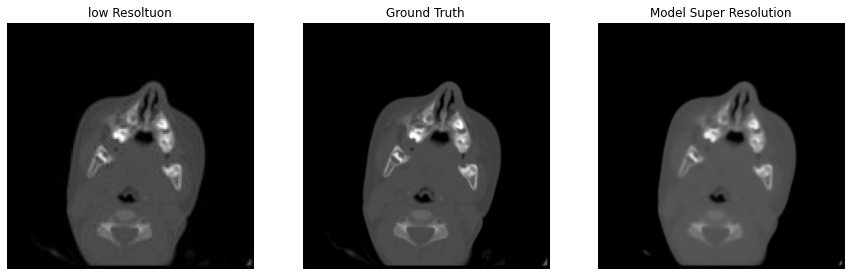

(150, 150, 3)
(600, 600, 3)


In [15]:
from PIL import Image
import numpy as np

def fuse_model_output(lr_image_path,gt , pre_generator, model):
    lr     = load_image(lr_image_path)
    gt     = load_image(gt)
    # Image pass to EDSR Model
    sr     = resolve_single(model, lr)
    
    # Output Image than pass to SR-Gans
    # Its amazing that I pass image of 300 * 300 to the mode
    # But the model is trained on image 150 * 150 as you can see above
    sr = np.asarray(Image.fromarray(sr.numpy()).resize((150,150)))
    pre_sr = resolve_single(pre_generator, sr)
    display([lr, gt, pre_sr ])
    return lr, pre_sr

lr, sr = fuse_model_output('docs/images/testing_image.jpg','docs/images/gt_testing_image.jpg', pre_generator, model)


print(lr.shape)
print(sr.shape)
    
    

